In [21]:
import os
import re
import unicodedata
from langchain.chains import RetrievalQA
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from funcs.logic import process_pdfs_to_faiss_with_positions
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from typing import TypedDict, List, Optional
from langgraph.graph import StateGraph
from funcs.logic import get_qa_score
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from docx import Document as DocxDocument
from tqdm import tqdm  # 진행 상황 표시용

source_dir = "data/source/docx"
output_dir = "data/vectordb/docx"
embedding_model = "intfloat/multilingual-e5-small"
# embedding_model = "intfloat/multilingual-e5-large-instruct"
chunk_size = 500  # 각 청크의 크기 (문자 수)
chunk_overlap = 50  # 청크 간 겹침 크기 (문자 수)

In [22]:
# 1️⃣ Word 문서에서 텍스트 추출하고 전처리하는 함수
def extract_and_preprocess_text_from_docx(file_path):
    try:
        doc = DocxDocument(file_path)
        # 문단 텍스트 추출 (빈 줄 제외)
        paragraphs = [para.text for para in doc.paragraphs if para.text.strip()]

        # 문단을 개행문자로 결합
        text = "\n".join(paragraphs)

        # 텍스트 전처리
        text = preprocess_text(text)

        return text
    except Exception as e:
        print(f"⚠️ {file_path} 파일 처리 중 오류 발생: {str(e)}")
        return ""

# 2️⃣ 텍스트 전처리 함수
def preprocess_text(text):
    # 한글 유니코드 정규화 (NFC)
    text = unicodedata.normalize('NFC', text)

    # 불필요한 특수 문자 및 공백 제거
    text = re.sub(r'[\u200b\u200c\u200d\u2060\ufeff]', '', text)  # 보이지 않는 특수 문자 제거
    text = re.sub(r'\s+', ' ', text)  # 연속된 공백 제거

    # 각 줄 앞뒤 공백 제거
    lines = [line.strip() for line in text.split('\n')]
    text = '\n'.join(lines)

    # 빈 줄 제거 (연속된 줄바꿈)
    text = re.sub(r'\n\s*\n', '\n', text)

    return text.strip()

# 3️⃣ 텍스트를 청크로 분할하는 함수
def create_chunks_from_texts(texts, metadata_list, chunk_size=500, chunk_overlap=50):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", ". ", "? ", "! ", " ", ""],
        length_function=len
    )

    documents = []
    for text, metadata in zip(texts, metadata_list):
        # 텍스트가 있는 경우에만 청킹 진행
        if text:
            chunks = text_splitter.split_text(text)
            # 각 청크별로 문서 생성
            for i, chunk in enumerate(chunks):
                chunk_metadata = metadata.copy()  # 원본 메타데이터 복사
                chunk_metadata["chunk_id"] = i    # 청크 ID 추가
                documents.append(Document(page_content=chunk, metadata=chunk_metadata))

    return documents

# 4️⃣ 메인 함수: 여러 개의 Word 파일을 읽어와서 벡터 DB 생성
def process_word_documents_to_vector_db(doc_dir, output_dir,
                                        embedding_model_name="intfloat/multilingual-e5-small",
                                        chunk_size=500, chunk_overlap=50):
    # Word 파일 목록 수집
    word_files = [f for f in os.listdir(doc_dir) if f.endswith(".docx")]

    if not word_files:
        print("⚠️ 처리할 Word 파일이 없습니다.")
        return

    print(f"🔍 총 {len(word_files)}개의 Word 파일을 처리합니다...")

    # 텍스트 추출 및 전처리
    texts = []
    metadata_list = []

    for file_name in tqdm(word_files, desc="파일 처리 중"):
        file_path = os.path.join(doc_dir, file_name)
        text = extract_and_preprocess_text_from_docx(file_path)

        if text:
            texts.append(text)
            # 메타데이터 생성 (파일명, 경로 등)
            metadata = {
                "source": file_name,
                "full_path": file_path,
                "file_type": "docx"
            }
            metadata_list.append(metadata)

    # 텍스트 청킹
    print(f"📄 텍스트를 청크 크기 {chunk_size}(겹침 {chunk_overlap})로 분할합니다...")
    documents = create_chunks_from_texts(texts, metadata_list, chunk_size, chunk_overlap)

    if not documents:
        print("⚠️ 처리할 문서가 없습니다.")
        return

    print(f"✅ {len(documents)}개의 청크가 생성되었습니다.")

    # 임베딩 모델 로드
    print(f"🧠 임베딩 모델 '{embedding_model_name}'을 로드합니다...")
    embedding_model = HuggingFaceEmbeddings(model_name=embedding_model_name)

    # FAISS 벡터 DB 생성
    print("🔢 벡터 DB를 생성합니다...")
    vector_db = FAISS.from_documents(documents, embedding_model)

    # 벡터 DB 저장
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    vector_db.save_local(output_dir)
    print(f"✅ '{output_dir}'에 벡터 데이터베이스 저장 완료")

    return vector_db

In [23]:
# 1️⃣ FAISS 벡터 DB 로드
qa_tokenizer = AutoTokenizer.from_pretrained("Dongjin-kr/ko-reranker")
qa_model = AutoModelForSequenceClassification.from_pretrained("Dongjin-kr/ko-reranker")


# 메인 함수 실행
vector_db = process_word_documents_to_vector_db(
    source_dir,
    output_dir,
    embedding_model,
    chunk_size,
    chunk_overlap
)


🔍 총 3개의 Word 파일을 처리합니다...


파일 처리 중: 100%|██████████| 3/3 [00:00<00:00, 65.50it/s]

📄 텍스트를 청크 크기 500(겹침 50)로 분할합니다...
✅ 94개의 청크가 생성되었습니다.
🧠 임베딩 모델 'intfloat/multilingual-e5-large-instruct'을 로드합니다...


🔢 벡터 DB를 생성합니다...
✅ 'data/docx'에 벡터 데이터베이스 저장 완료


In [24]:
# LangGraph pipeline 실행
class QAState(TypedDict):
    question: str
    retrieved_docs: Optional[List]
    reranked_docs: Optional[List]
    top_docs: Optional[List]
    answer: Optional[str]


def retrieve_documents(state: QAState):
    question = state["question"]
    retrieved_docs = vector_db.similarity_search_with_score(question, k=30)
    return {"retrieved_docs": retrieved_docs}


def rerank_documents(state: QAState):
    question = state["question"]
    retrieved_docs = state["retrieved_docs"]

    scored_docs = []
    _score = []
    for doc, _ in retrieved_docs:
        score = get_qa_score(question, doc.page_content, qa_tokenizer, qa_model)
        scored_docs.append((doc, score))
        _score.append(score)

    _average = sum(_score) / len(_score)

    reranked_docs = sorted(scored_docs, key=lambda x: x[1], reverse=True)
    # top_docs = [doc for doc, _ in reranked_docs[:10]]
    top_docs = []
    for doc, score in reranked_docs[:10]:
        doc.metadata["score"] = score
        if score > _average:
            top_docs.append(doc)

    return {
        "reranked_docs": reranked_docs,
        "top_docs": top_docs,
    }





In [25]:
graph = StateGraph(QAState)

graph.add_node("retrieve_documents", retrieve_documents)
graph.add_node("rerank_documents", rerank_documents)

graph.set_entry_point("retrieve_documents")
graph.add_edge("retrieve_documents", "rerank_documents")


graph.set_finish_point("retrieve_documents")

qa_graph = graph.compile()


In [26]:
import csv
checklist_url = "data/checklist.csv"

# CSV 파일을 읽어 딕셔너리 리스트로 저장
data_list = []
with open(checklist_url, newline='', encoding="utf-8-sig") as csvfile:
    reader = csv.DictReader(csvfile)  # 각 행을 딕셔너리로 변환
    for row in reader:
        op = {
            'code':row['code'],
            'item':row['item'],
            'exp' : row['exp'],
              }
        result = qa_graph.invoke({"question": f"{row['item']}"})

        op['result'] = result
        data_list.append(op)

/Users/peter/Documents/.virtual/RAG_experiments/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/peter/Documents/.virtual/RAG_experiments/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/peter/Documents/.virtual/RAG_experiments/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/peter/Documents/.virtual/RAG_experiments/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/peter/Documents/.virtual/RAG_experiments/lib/python3.11/site-packages/IPy

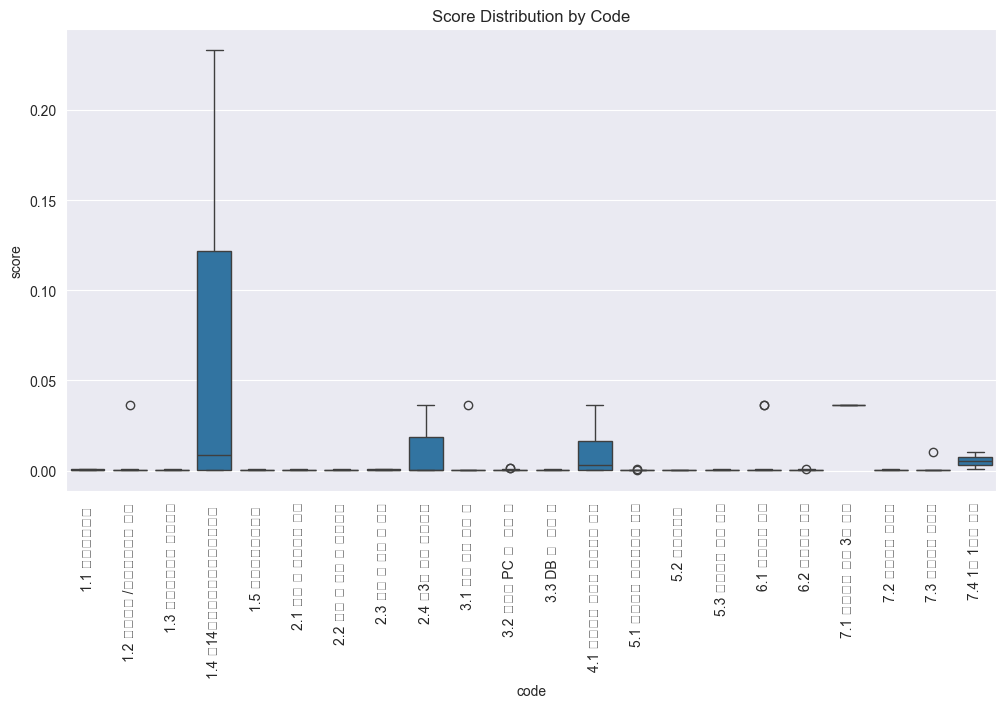

In [27]:
import pandas as pd


result_list = []
for _documents in data_list:
    for _docs in _documents['result']['top_docs']:
        _dummy = {
            "code":_documents['code'],
            "item":_documents['item'],
            "page_content": _docs.page_content,
            "score": _docs.metadata['score'],
        }
        result_list.append(_dummy)


df = pd.DataFrame(result_list)



mean_scores = df.groupby('code')['score'].mean().reset_index()

import seaborn as sns
import matplotlib.pyplot as plt




# 박스 플롯 그리기
plt.figure(figsize=(12, 6))
sns.boxplot(x='code', y='score', data=df)
plt.xticks(rotation=90)
plt.title('Score Distribution by Code')
plt.show()

In [28]:
result_list

[{'code': '1.1 개인정보수집\xa0',
  'item': '○ 법률 및 법령 등에서 정한 소관업무에 따라 개인정보를 수집하고 있는가?',
  'page_content': '. 단, 이것이 회사의 고의∙과실로 인하여 야기된 경우는 회사가 책임을 부담합니다. ② 회원은 회원 ID, 비밀번호 및 추가정보 등을 도난 당하거나 제3자가 사용하고 있음을 인지한 경우에는 즉시 본인의 비밀번호를 수정하는 등의 조치를 취하여야 하며 즉시 이를 회사에 통보하여 회사의 안내를 따라야 합니다. 제 6 조 개인정보의 수집 등 회사는 서비스를 제공하기 위하여 관련 법령의 규정에 따라 회원으로부터 필요한 개인정보를 수집합니다. 제 7 조 회원정보의 변경 회원은 아래 각 호의 1에 해당하는 사항이 변경되었을 경우 즉시 회원정보 관리페이지에서 이를 변경하여야 합니다. 이 경우 회사는 회원이 회원정보를 변경하지 아니하여 발생한 손해에 대하여 책임을 부담하지 아니하며, 법인 회원의 경우에는 회사가 별도로 정하는 방법으로 변경할 수 있습니다. 1. 생년월일, 거주지역 및 연락처 등 2. 우편/경품 수신 주소, 취미•관심사 등 3. 서비스별 뉴스레터 수신 여부 등 4',
  'score': 0.0005283846985548735},
 {'code': '1.1 개인정보수집\xa0',
  'item': '○ 법률 및 법령 등에서 정한 소관업무에 따라 개인정보를 수집하고 있는가?',
  'page_content': '. 정보통신망법 등 관련 법령에 의하여 그 전송 또는 게시가 금지되는 정보(컴퓨터 프로그램 등)를 전송하거나 게시하는 행위 9. 청소년보호법에서 규정하는 청소년유해매체물을 게시하는 행위 10. 공공질서 또는 미풍양속에 위배되는 내용의 정보, 문장, 도형, 음성 등을 유포하는 행위 11. 회사의 직원이나 서비스의 관리자를 가장하거나 사칭하여 또는 타인의 명의를 모용하여 글을 게시하거나 메일을 발송하는 행위 12. 컴퓨터 소프트웨어, 하드웨어, 전기통신 장비의 정상적인 가동을 방해,

In [30]:
df

,code,item,page_content,score
0,1.1 개인정보수집,○ 법률 및 법령 등에서 정한 소관업무에 따라 개인정보를 수집하고 있는가?,". 단, 이것이 회사의 고의∙과실로 인하여 야기된 경우는 회사가 책임을 부담합니다....",0.000528
1,1.1 개인정보수집,○ 법률 및 법령 등에서 정한 소관업무에 따라 개인정보를 수집하고 있는가?,. 정보통신망법 등 관련 법령에 의하여 그 전송 또는 게시가 금지되는 정보(컴퓨터 ...,0.000318
2,1.1 개인정보수집,○ 법률 및 법령 등에서 정한 소관업무에 따라 개인정보를 수집하고 있는가?,". 다른 회원의 개인정보를 그 동의 없이 수집, 저장, 공개하는 행위 15. 불특정...",0.000173
3,1.1 개인정보수집,○ 법률 및 법령 등에서 정한 소관업무에 따라 개인정보를 수집하고 있는가?,". 다만, 여러분은 이용제한과 관련하여 조치 결과가 불만족스러울 경우 고객센터를 통...",0.000182
4,1.1 개인정보수집,○ 법률 및 법령 등에서 정한 소관업무에 따라 개인정보를 수집하고 있는가?,. ② 회사는 법령에서 정하는 기간 동안 여러분이 카카오계정 서비스를 이용하기 위해...,0.000143
...,...,...,...,...
190,7.3 접근권한 최소화,○ 업무에 필요한 최소한의 권한만 부여되고 있는가?,. 회사가 제공하는 서비스를 이용하여 제3자에게 본인을 홍보할 기회를 제공 하거나 ...,0.000192
191,7.3 접근권한 최소화,○ 업무에 필요한 최소한의 권한만 부여되고 있는가?,". 다른 회원의 개인정보를 그 동의 없이 수집, 저장, 공개하는 행위 15. 불특정...",0.000173
192,7.3 접근권한 최소화,○ 업무에 필요한 최소한의 권한만 부여되고 있는가?,. 재게시 청구가 없는 경우 해당 게시물 등은 임시조치 기간 만료 이후 삭제됩니다....,0.000121
193,7.4 1인 1계정 사용,"○ 취급자계정을 1인1계정 사용하고 있는가?(1인 다계정, 공용아이디 사용 등 확인)",. 사업자/단체 카카오계정의 이용 및 관리에 관한 책임은 해당 사업자/단체에 있으며...,0.010108


In [ ]:
data_list

In [32]:
question = "이용제한과 관련하여 조치 결과가 불만족스러울 경우 고객센터를 통해 이의를 제기할 수 있습니까?"
result = qa_graph.invoke({"question": f"{question}"})

In [33]:
result.keys()

dict_keys(['question', 'retrieved_docs', 'reranked_docs', 'top_docs'])

In [38]:
for i in result['top_docs']:
    print(i)
    print("------------")

page_content='. 다만, 여러분은 이용제한과 관련하여 조치 결과가 불만족스러울 경우 고객센터를 통해 이의를 제기할 수 있습니다. 회사는 법령에서 정하는 기간 동안 여러분이 서비스를 이용하기 위해 로그인 혹은 접속한 기록이 없는 경우 여러분이 카카오 서비스 내 등록한 이메일주소, 휴대폰번호로 이메일, 문자메시지 또는 카카오톡 메시지를 보내는 등 기타 유효한 수단으로 통지 후 여러분의 정보를 파기하거나 분리 보관할 수 있으며, 이로 인해 서비스 이용을 위한 필수적인 정보가 부족할 경우 이용계약이 해지될 수도 있습니다. 카카오 서비스 내 금지되는 서비스 이용 활동 및 그에 따른 카카오 서비스 이용제한과 카카오 서비스 휴면정책 등 그 밖에 카카오 서비스의 이용에 관한 보다 자세한 사항은 카카오 운영정책을 참고해 주시기 바랍니다. 법률에 따라 게시물을 관리할 수 있습니다' metadata={'source': '카카오 서비스 약관20230109.docx', 'full_path': 'data/source/docx/카카오 서비스 약관20230109.docx', 'file_type': 'docx', 'chunk_id': 9, 'score': 0.9999492168426514}
------------
page_content='. ③ 혹시라도 여러분이 관련 법령, 회사의 모든 약관 또는 정책을 준수하지 않는다면, 회사는 여러분의 위반행위 등을 조사할 수 있고, 여러분의 계정・서비스 이용을 잠시 또는 계속하여 중단하거나, 재가입에 제한을 둘 수도 있습니다. 또한 여러분이 서비스와 관련된 설비의 오작동이나 시스템의 파괴 및 혼란을 유발하는 등 서비스 제공에 악영향을 미치거나 안정적 운영을 심각하게 방해한 경우, 회사는 이러한 위험 활동이 확인된 여러분의 계정들에 대하여 이용제한을 할 수 있습니다. 다만, 여러분은 이용제한과 관련하여 조치 결과가 불만족스러울 경우 고객센터를 통해 이의를 제기할 수 있습니다. ④ 본 조에서 정한 사항 및 그 밖에 카카오계정 서비스의 이용에 관